In [2]:
using Bootstrap
using CSV
using CategoricalArrays
using Chain
using DataFrames
import Downloads
using GLM
using Plots
using Random
using StatsPlots
using Statistics

In [3]:
ENV["LINES"] = 20
ENV["COLUMNS"] = 1000

1000

In [4]:
Downloads.download("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Participation.csv", "participation.csv")

"participation.csv"

In [6]:
df_raw = CSV.read("participation.csv", DataFrame)

,Column1,lfp,lnnlinc,age,educ,nyc,noc,foreign
,Int64,String,Float64,Float64,Int64,Int64,Int64,String
1,1,no,10.7875,3.0,8,1,1,no
2,2,yes,10.5243,4.5,8,0,1,no
3,3,no,10.9686,4.6,9,0,0,no
4,4,no,11.105,3.1,11,2,0,no
5,5,no,11.1085,4.4,12,0,2,no
6,6,yes,11.0283,4.2,12,0,1,no
7,7,no,11.4547,5.1,8,0,0,no
8,8,yes,10.4909,3.2,8,0,2,no
9,9,no,10.6247,3.9,12,0,0,no


In [7]:
df = select(df_raw,
            :lfp => (x -> recode(x, "yes" => 1, "no" => 0)) => :lfp,
            :lnnlinc,
            :age,
            :age => ByRow(x -> x^2) => :age²,
            Between(:educ, :noc),
            :foreign => categorical => :foreign)

,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,1,10.5243,4.5,20.25,8,0,1,no
3,0,10.9686,4.6,21.16,9,0,0,no
4,0,11.105,3.1,9.61,11,2,0,no
5,0,11.1085,4.4,19.36,12,0,2,no
6,1,11.0283,4.2,17.64,12,0,1,no
7,0,11.4547,5.1,26.01,8,0,0,no
8,1,10.4909,3.2,10.24,8,0,2,no
9,0,10.6247,3.9,15.21,12,0,0,no


In [8]:
@chain df begin
    groupby(:lfp)
    combine([:lnnlinc, :age, :educ, :nyc, :noc] .=> mean)
end

,lfp,lnnlinc_mean,age_mean,educ_mean,nyc_mean,noc_mean
,Int64,Float64,Float64,Float64,Float64,Float64
1,0,10.7513,4.08535,9.59448,0.409766,0.902335
2,1,10.6083,3.89002,8.97007,0.197007,1.07731


In [9]:
@chain df begin
    groupby([:lfp, :foreign])
    combine(nrow)
    unstack(:lfp, :foreign, :nrow)
    select(:lfp, [:no, :yes] => ByRow((x, y) -> y / (x + y)) => :foreign_yes)
end

,lfp,foreign_yes
,Int64,Float64
1,0,0.146497
2,1,0.366584


In [10]:
gd = groupby(df, :lfp)

,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,0,10.7875,3.0,9.0,8,1,1,no
2,0,10.9686,4.6,21.16,9,0,0,no
3,0,11.105,3.1,9.61,11,2,0,no
4,0,11.1085,4.4,19.36,12,0,2,no
5,0,11.4547,5.1,26.01,8,0,0,no
6,0,10.6247,3.9,15.21,12,0,0,no
7,0,10.4864,4.3,18.49,11,0,2,no
8,0,10.6606,4.5,20.25,11,0,2,no
9,0,10.4676,6.0,36.0,12,0,0,no


In [13]:
gd[2]

,lfp,lnnlinc,age,age²,educ,nyc,noc,foreign
,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Cat…
1,1,10.5243,4.5,20.25,8,0,1,no
2,1,11.0283,4.2,17.64,12,0,1,no
3,1,10.4909,3.2,10.24,8,0,2,no
4,1,11.844,3.9,15.21,12,0,0,no
5,1,10.9578,5.3,28.09,11,0,0,no
6,1,11.1081,4.6,21.16,11,0,1,no
7,1,10.484,5.4,29.16,8,0,0,no
8,1,10.6012,4.7,22.09,8,0,0,no
9,1,10.8411,4.9,24.01,12,0,0,no


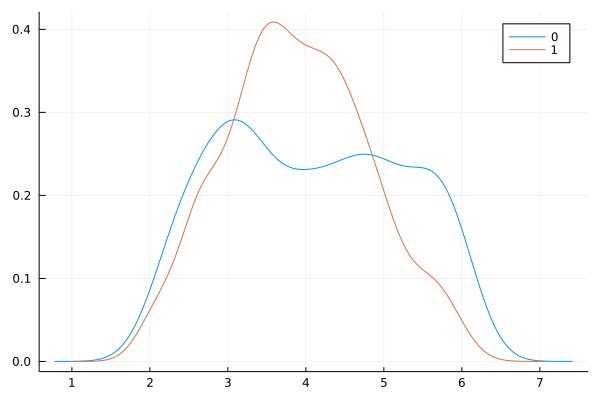

In [14]:
@df df density(:age, group=:lfp)

In [15]:
probit = glm(@formula(lfp ~ lnnlinc + age + age² + educ + nyc + noc + foreign),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + age² + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age²          -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.146985  

In [16]:
probit = glm(Term(:lfp) ~ sum(Term.(propertynames(df)[2:end])),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + age² + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age²          -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.146985  

In [17]:
Term(:lfp) ~ sum(Term.(propertynames(df)[2:end]))

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  age²(unknown)
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

In [18]:
@formula(lfp ~ lnnlinc + age + age² + educ + nyc + noc + foreign)

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  age²(unknown)
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

In [19]:
probit = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
             df, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + :(age ^ 2) + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age ^ 2       -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.14

In [20]:
@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign)

FormulaTerm
Response:
  lfp(unknown)
Predictors:
  lnnlinc(unknown)
  age(unknown)
  (age)->age ^ 2
  educ(unknown)
  nyc(unknown)
  noc(unknown)
  foreign(unknown)

In [21]:
df_pred = DataFrame(lnnlinc=10.0, age= 2.0:0.01:6.2, educ = 9, nyc = 0, noc = 1, foreign = "yes")

,lnnlinc,age,educ,nyc,noc,foreign
,Float64,Float64,Int64,Int64,Int64,String
1,10.0,2.0,9,0,1,yes
2,10.0,2.01,9,0,1,yes
3,10.0,2.02,9,0,1,yes
4,10.0,2.03,9,0,1,yes
5,10.0,2.04,9,0,1,yes
6,10.0,2.05,9,0,1,yes
7,10.0,2.06,9,0,1,yes
8,10.0,2.07,9,0,1,yes
9,10.0,2.08,9,0,1,yes


In [22]:
probit_pred = predict(probit, df_pred, interval=:confidence)

,prediction,lower,upper
,Float64?,Float64?,Float64?
1,0.786122,0.636712,0.891844
2,0.78872,0.641194,0.892941
3,0.791282,0.645623,0.894026
4,0.79381,0.650001,0.895097
5,0.796302,0.654325,0.896155
6,0.79876,0.658597,0.8972
7,0.801183,0.662817,0.898233
8,0.803572,0.666983,0.899252
9,0.805928,0.671097,0.90026


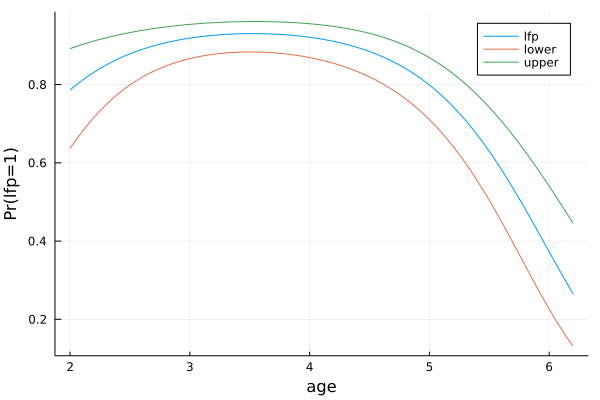

In [23]:
plot(df_pred.age, Matrix(probit_pred), labels=["lfp" "lower" "upper"],
     xlabel="age", ylabel="Pr(lfp=1)")

In [24]:
probit

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lfp ~ 1 + lnnlinc + age + :(age ^ 2) + educ + nyc + noc + foreign

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)    3.74896     1.40663     2.67    0.0077   0.992006   6.50591
lnnlinc       -0.666932    0.13192    -5.06    <1e-06  -0.92549   -0.408374
age            2.07531     0.405407    5.12    <1e-06   1.28073    2.86989
age ^ 2       -0.294345    0.0499446  -5.89    <1e-08  -0.392235  -0.196456
educ           0.0191963   0.0179255   1.07    0.2842  -0.015937   0.0543295
nyc           -0.714465    0.100397   -7.12    <1e-11  -0.911238  -0.517691
noc           -0.14

In [25]:
function boot_sample(df)
    df_boot = df[rand(1:nrow(df), nrow(df)), :]
    probit_boot = glm(@formula(lfp ~ lnnlinc + age + age^2 + educ + nyc + noc + foreign),
                      df_boot, Binomial(), ProbitLink())
    return (; (Symbol.(coefnames(probit_boot)) .=> coef(probit_boot))...)
end

boot_sample (generic function with 1 method)

In [27]:
function run_boot(df, reps)
    coef_boot = DataFrame()
    for _ in 1:reps
        push!(coef_boot, boot_sample(df))
    end
    return coef_boot
end

run_boot (generic function with 1 method)

In [28]:
Random.seed!(1234)
@time coef_boot = run_boot(df, 1000)

  4.853913 seconds (6.58 M allocations: 964.751 MiB, 4.34% gc time)


,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.27668,-0.685018,2.43103,-0.346242,0.0358374,-0.656125,-0.204708,0.897463
2,3.46174,-0.604296,1.80522,-0.271183,0.0344276,-0.830026,-0.112685,0.849524
3,5.58553,-0.931202,2.56893,-0.351696,0.0088754,-0.661503,-0.132513,0.751413
4,5.36834,-0.869949,2.47276,-0.348879,0.0102268,-0.680439,-0.117942,0.460296
5,5.02884,-0.815314,2.23525,-0.309316,0.0122217,-0.679034,-0.156954,0.627065
6,3.18287,-0.66076,2.31433,-0.321379,0.019614,-0.716859,-0.178211,0.786647
7,5.90148,-0.781129,1.54387,-0.242073,0.0365077,-0.771876,-0.0974262,0.784947
8,2.91324,-0.502556,1.47766,-0.21431,0.0222138,-0.638783,-0.130559,0.785572
9,2.26184,-0.58512,2.32937,-0.325795,0.0320947,-0.695273,-0.109318,0.726193


In [29]:
conf_boot = mapcols(x -> quantile(x, [0.025, 0.975]), coef_boot)

,(Intercept),lnnlinc,age,age ^ 2,educ,nyc,noc,foreign: yes
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.06625,-0.94311,1.24434,-0.397132,-0.0154263,-0.937041,-0.251984,0.469018
2,6.59637,-0.424606,2.91247,-0.191457,0.0543084,-0.525028,-0.0503898,0.972134
